In [1]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import concatenate, Lambda, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import keras.backend as K
from keras.datasets import cifar10
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
import cv2

import itertools
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pydot
from IPython.display import SVG

In [2]:
def getimages(direct):
    im=[]
    label=[]
    lab=0
    for labels in os.listdir(direct):
        #Label corresponding to folder
        if labels=="buildings":
            lab=0
        if labels=="forest":
            lab=1
        if labels=="glacier":
            lab=2
        if labels=="mountain":
            lab=3
        if labels=="sea":
            lab=4
        if labels=="street":
            lab=5
        for image in os.listdir(direct+r'/'+labels):
            #Read images
            imag=cv2.imread(direct+r'/'+labels+r'/'+image)
            imag=cv2.resize(imag,(150,150))
            
            im.append(imag)
            label.append(lab)
    #Suffle all images
    return shuffle(im, label)

#Obtain both train and test images
im,label=getimages("archive\seg_train\seg_train")      
im1,label1=getimages("archive\seg_test\seg_test") 
img=im+im1
lab=label+label1

#Convert to numpy array
Images=np.array(img)
Labels=np.array(lab)

classes=3

In [3]:
classes=3
#Split into train, validation and test
x1, xtest, y1,ytest=train_test_split(Images, Labels, random_state=0)
xtrain, xvalidation, ytrain, yvalidation=train_test_split(x1, y1, random_state=0)

#Prepare x
xtrain = xtrain.astype('float32')
xvalidation = xvalidation.astype('float32')
xtest=xtest.astype('float32')
xtrain /= 255
xvalidation /= 255
xtest /= 255


#Prepare y
ytrainG = np.array([0 if i in [0,5] else 1 if i in [1] else 2 for i in ytrain])
yvalidationG = np.array([0 if i in [0,5] else 1 if i in [1] else 2 for i in yvalidation])
ytestG = np.array([0 if i in [0,5] else 1 if i in [1] else 2 for i in ytest])
ytrainG0 = keras.utils.to_categorical(ytrainG, classes)
yvalidationG0 = keras.utils.to_categorical(yvalidationG, classes)
ytestG0=keras.utils.to_categorical(ytestG, classes)

In [4]:
# Small VGG-like model
def simpleVGG(im_Input, num_classes, name="vgg"):
    name = [name+str(i) for i in range(12)]
    
    # convolution and max pooling layers
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[0])(im_Input)
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[1])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[2])(vgg)
    vgg = Dropout(0.25, name=name[3])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[6])(vgg)
    vgg = Dropout(0.25, name=name[7])(vgg)

    # classification layers
    vgg = Flatten(name=name[8])(vgg)
    vgg = Dense(512, activation='relu', name=name[9])(vgg)
    vgg = Dropout(0.5, name=name[10])(vgg)
    vgg = Dense(num_classes, activation='softmax', name=name[11])(vgg)
    return vgg

In [5]:
im_Input = Input(shape=(xtrain.shape[1:]), name="input")
base0VGG = simpleVGG(im_Input, classes, "base")
base0Model = Model(im_Input, base0VGG)
# compile
base0Model.compile(loss='categorical_crossentropy',
                   optimizer=Adam(),
                   metrics=['accuracy'])

In [6]:
# get the newest model file within a directory
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model

In [7]:
# make saving directory for check point
gate0SaveDir = "./3_classes/"
if not os.path.isdir(gate0SaveDir):
    os.makedirs(gate0SaveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(gate0SaveDir, '3_classes_.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data from the directory if exists
base0Model = getNewestModel(base0Model, gate0SaveDir)

In [47]:
# Number of training/testing examples per batch
batch_size = 50

# Training epochs. A higher number of epochs corresponds to "more fitting to training data"
epochs = 10

# train
history=base0Model.fit(xtrain, ytrainG0,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(xvalidation, yvalidationG0),
               callbacks=[es_cb,cp_cb])

Epoch 1/10
192/192 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.8124
Epoch 00001: val_loss improved from inf to 0.30299, saving model to ./3_classes\3_classes_.01-0.30.hdf5
192/192 [==============================] - 511s 3s/step - loss: 0.5456 - accuracy: 0.8124 - val_loss: 0.3030 - val_accuracy: 0.8967
Epoch 2/10
192/192 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9166
Epoch 00002: val_loss improved from 0.30299 to 0.24477, saving model to ./3_classes\3_classes_.02-0.24.hdf5
192/192 [==============================] - 518s 3s/step - loss: 0.2393 - accuracy: 0.9166 - val_loss: 0.2448 - val_accuracy: 0.9255
Epoch 3/10
192/192 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9322
Epoch 00003: val_loss improved from 0.24477 to 0.20492, saving model to ./3_classes\3_classes_.03-0.20.hdf5
192/192 [==============================] - 538s 3s/step - loss: 0.1952 - accuracy: 0.9322 - val_loss: 0.2049 - val_accuracy: 0.9

In [11]:
# evaluate
base0Model = getNewestModel(base0Model, gate0SaveDir)
baseScore = base0Model.evaluate(xtest, ytestG0)
print(baseScore)

134/134 [==============================] - 53s 399ms/step - loss: 0.2705 - accuracy: 0.9056
[0.2705335319042206, 0.9056116342544556]


In [54]:
y_pred = base0Model.predict(xtest)
matrix = confusion_matrix(ytestG0.argmax(axis=1), y_pred.argmax(axis=1))

In [50]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
         print("Confusion matrix, without normalization")
 
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label") 

Normalized confusion matrix


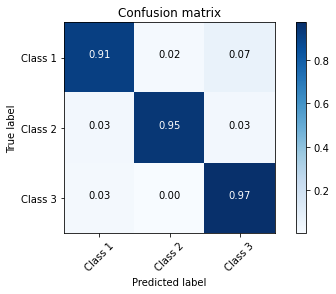

In [55]:
plot_confusion_matrix(matrix, ["Class 1", "Class 2", "Class 3"], normalize=True)

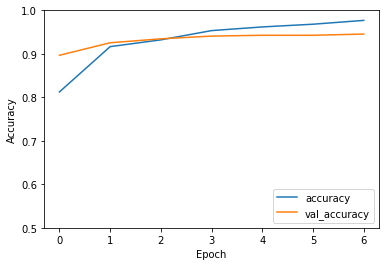

In [53]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')